## Survival Chance Estimator.

### Load in Dataset and Modules.

In [1]:
# import typical modules.
import pandas as pd
import numpy as np

# for visualisation.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set notebook style.
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

# import warnings.
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# load data into pandas dataframe.
titanic = sns.load_dataset('titanic')

# take a look at the first five rows of data.
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Data Exploration to better understand the data.

In [3]:
# let's see the data info.
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
# take a look at the brief discription of the data.
titanic.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [5]:
# let's see only object columns.
titanic.describe(include = ['object', 'category']).T

,count,unique,top,freq
sex,891,2,male,577
embarked,889,3,S,644
class,891,3,Third,491
who,891,3,man,537
deck,203,7,C,59
embark_town,889,3,Southampton,644
alive,891,2,no,549


In [6]:
# let's see. how many null values we have in our data.
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

### Data Preprocessing

In [7]:
# drop deck column since it contains a ton of null values.
titanic.drop(['deck'], axis = 1, inplace = True)

In [8]:
# drop 2 rows which contain null value in embark_town column.
titanic.dropna(axis = 0, subset = ['embark_town'], inplace = True)

# make sure that our task has been done well.
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
embark_town      0
alive            0
alone            0
dtype: int64

### Category Encoding

In [9]:
# Split features and label.

X_null = titanic.drop(['age', 'alive', 'class', 'embarked'], axis = 1)
y_null = titanic['age']

In [10]:
object_cols = [col for col in X_null.columns if X_null[col].dtypes in ['object', 'category', 'bool']]

object_cols

['sex', 'who', 'adult_male', 'embark_town', 'alone']

OrdinalEncoder

In [11]:
#import category_encoder.
from sklearn.preprocessing import OrdinalEncoder
OE = OrdinalEncoder()

# encode catgory variables.
X_null[object_cols] = OE.fit_transform(X_null[object_cols])

X_null.head()

,survived,pclass,sex,sibsp,parch,fare,who,adult_male,embark_town,alone
0,0,3,1.0,1,0,7.2500,1.0,1.0,2.0,0.0
1,1,1,0.0,1,0,71.2833,2.0,0.0,0.0,0.0
2,1,3,0.0,0,0,7.9250,2.0,0.0,2.0,1.0
3,1,1,0.0,1,0,53.1000,2.0,0.0,2.0,0.0
4,0,3,1.0,0,0,8.0500,1.0,1.0,2.0,1.0


Fill NaN values in age column using linearRegression.

In [12]:
#  get indexes of samples with null values.
rows_with_null = y_null.isnull()

# select null and no null values.
null_rows = rows_with_null[rows_with_null == True]
no_null_rows = rows_with_null[rows_with_null == False]

# get indexes.
null_rows_index = null_rows.index
no_null_rows_index = no_null_rows.index

Break off holdout set from training set.

In [13]:
# training set.
X_train_null = X_null.loc[no_null_rows_index, :]
y_train_null = y_null.loc[no_null_rows_index,]

# holdout
X_test_null = X_null.loc[null_rows_index, :]
y_test_null = y_null.loc[null_rows_index,]

X_train_null.shape, y_train_null.shape, X_test_null.shape, y_test_null.shape

((712, 10), (712,), (177, 10), (177,))

Let's see correlations between features and label.

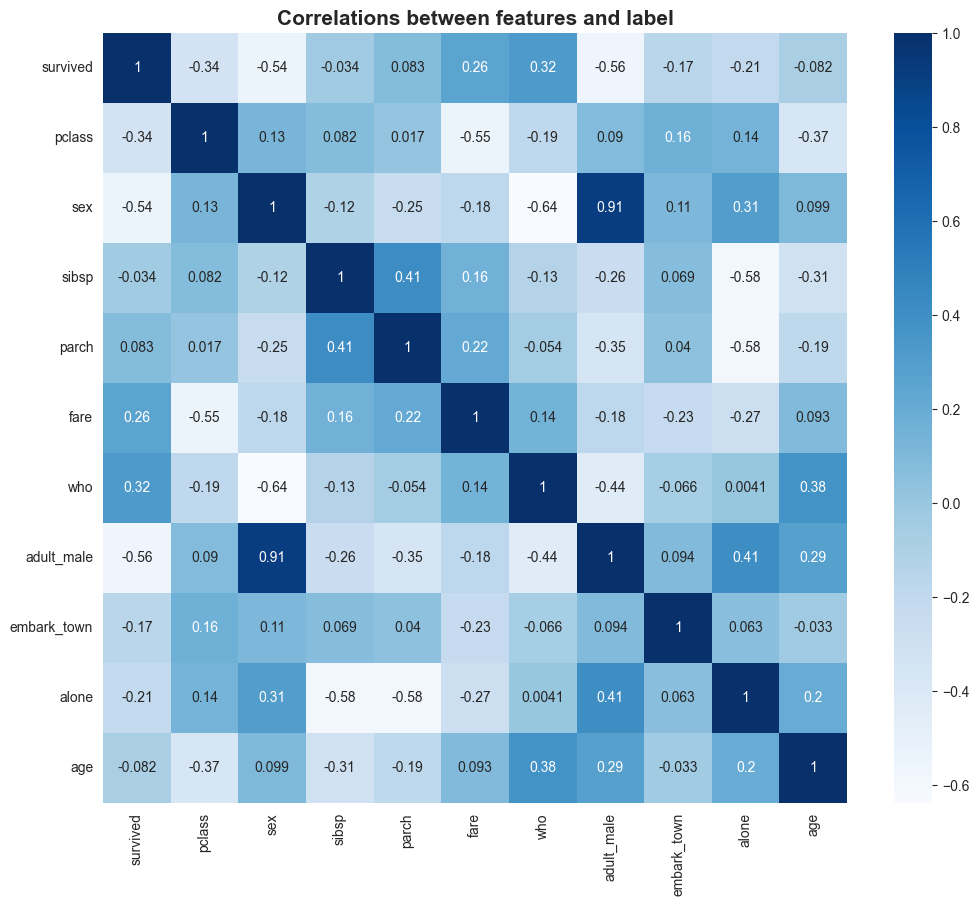

In [14]:
# concat features and label.
null_df = pd.concat([X_null, y_null], axis = 1)

# get correlations.
corr = null_df.corr()

# set figure size.
plt.figure(figsize = (12, 10))
# heatmap which shows correlations.
ax = sns.heatmap(corr, annot = True, cmap = 'Blues')
ax.set_title('Correlations between features and label', size = 15, weight = 600)
plt.show()

In [15]:
# make correlations dataframe.
target_corr = corr['age'].sort_values(ascending = False)
target_corr = target_corr.to_frame()
target_corr.style.background_gradient(cmap = 'Blues')

,age
age,1.000000
who,0.375849
adult_male,0.286543
alone,0.195766
sex,0.099037
fare,0.093143
embark_town,-0.032565
survived,-0.082446
parch,-0.187896
sibsp,-0.307351


In [16]:
y_train_null[:5].to_list()

[22.0, 38.0, 26.0, 35.0, 35.0]

Train Model to fill NaN values.

In [17]:
# import LinearRegression.
from sklearn.linear_model import LinearRegression

# initialise the model.
linear_fillna = LinearRegression()

# train the model.
linear_fillna.fit(X_train_null, y_train_null)

LinearRegression()

In [19]:
preds = linear_fillna.predict(X_train_null[:5])

print('Actual :', (y_train_null[:5].tolist()))
print('Predicted ;', preds.round())

Actual : [22.0, 38.0, 26.0, 35.0, 35.0]
Predicted ; [28. 36. 25. 36. 30.]


In [20]:
X_test_null

,survived,pclass,sex,sibsp,parch,fare,who,adult_male,embark_town,alone
5,0,3,1.0,0,0,8.4583,1.0,1.0,1.0,1.0
17,1,2,1.0,0,0,13.0000,1.0,1.0,2.0,1.0
19,1,3,0.0,0,0,7.2250,2.0,0.0,0.0,1.0
26,0,3,1.0,0,0,7.2250,1.0,1.0,0.0,1.0
28,1,3,0.0,0,0,7.8792,2.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
859,0,3,1.0,0,0,7.2292,1.0,1.0,0.0,1.0
863,0,3,0.0,8,2,69.5500,2.0,0.0,2.0,0.0
868,0,3,1.0,0,0,9.5000,1.0,1.0,2.0,1.0
878,0,3,1.0,0,0,7.8958,1.0,1.0,2.0,1.0


In [21]:
# get predictions

predictions = linear_fillna.predict(X_test_null)

predictions = predictions.round()

Fill NaN

In [22]:
# fill NaN with estimated values.

titanic.loc[null_rows_index, 'age'] = predictions

In [23]:
titanic.loc[null_rows_index, :]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
5,0,3,male,30.0,0,0,8.4583,Q,Third,man,True,Queenstown,no,True
17,1,2,male,33.0,0,0,13.0000,S,Second,man,True,Southampton,yes,True
19,1,3,female,26.0,0,0,7.2250,C,Third,woman,False,Cherbourg,yes,True
26,0,3,male,30.0,0,0,7.2250,C,Third,man,True,Cherbourg,no,True
28,1,3,female,26.0,0,0,7.8792,Q,Third,woman,False,Queenstown,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,male,30.0,0,0,7.2292,C,Third,man,True,Cherbourg,no,True
863,0,3,female,26.0,8,2,69.5500,S,Third,woman,False,Southampton,no,False
868,0,3,male,30.0,0,0,9.5000,S,Third,man,True,Southampton,no,True
878,0,3,male,30.0,0,0,7.8958,S,Third,man,True,Southampton,no,True


Feature Engineering.

In [24]:
# family size.
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,family_size
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False,2
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False,2
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False,2
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True,1


In [25]:
titanic.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
family_size    0
dtype: int64

### Data Visualisation

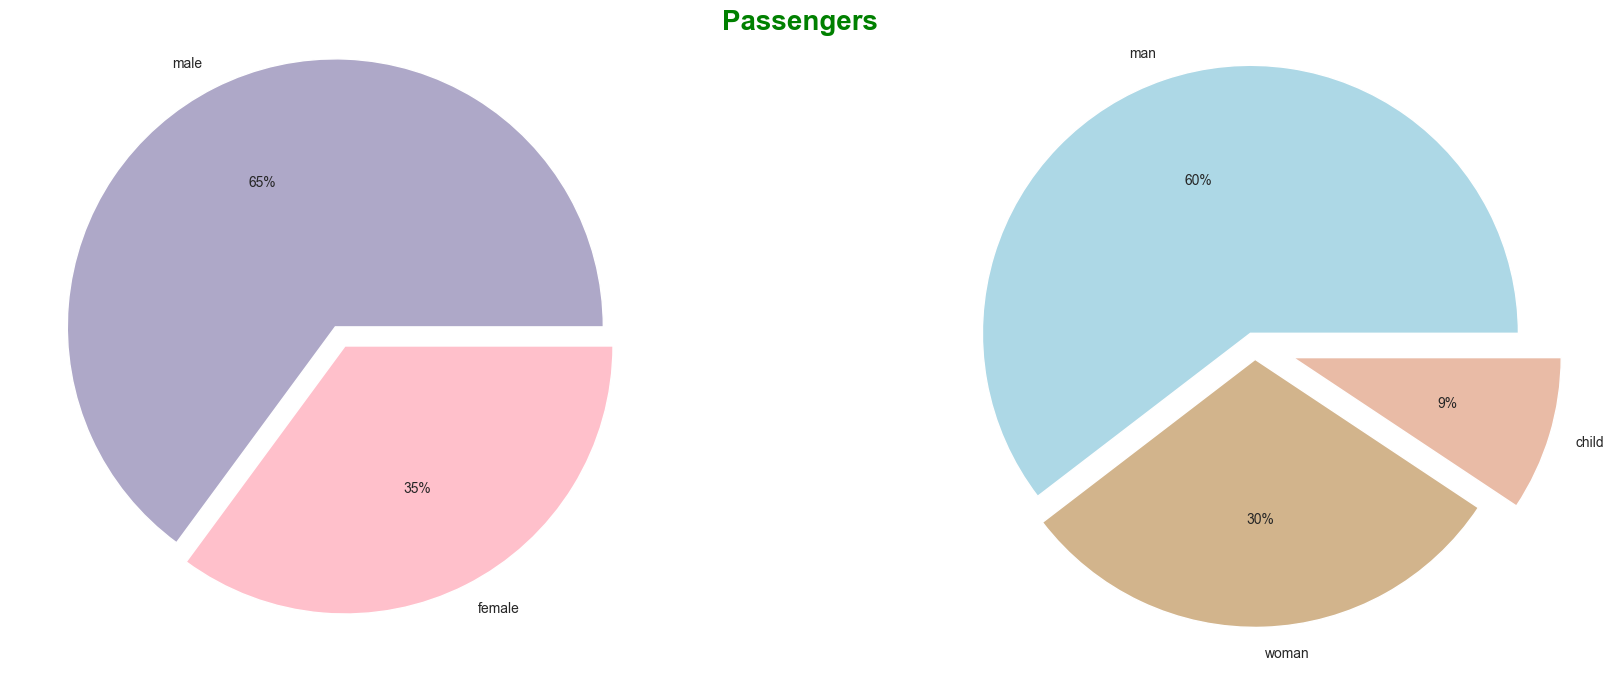

In [26]:
# set figure size
# plt.figure(figsize = (6, 6))

fig, axes = plt.subplots(1, 2, figsize = (20, 7))
explodes = [[0.08, 0], [0.05, 0.05, 0.15]]
colours = [['#aea8c8', 'pink'], ['lightblue', 'tan', '#e9bba6']]
           
for i, name in enumerate(['sex', 'who']):
    # pie plot
    axes[i].pie(titanic[name].value_counts(), labels = titanic[name].value_counts().index,
            autopct = '%1.0f%%', explode = explodes[i] , colors = colours[i])
plt.tight_layout()
plt.suptitle('Passengers', size = 20, weight = 'bold', color = 'green')
plt.show()

In [27]:
sns.set_palette('PuOr_r')

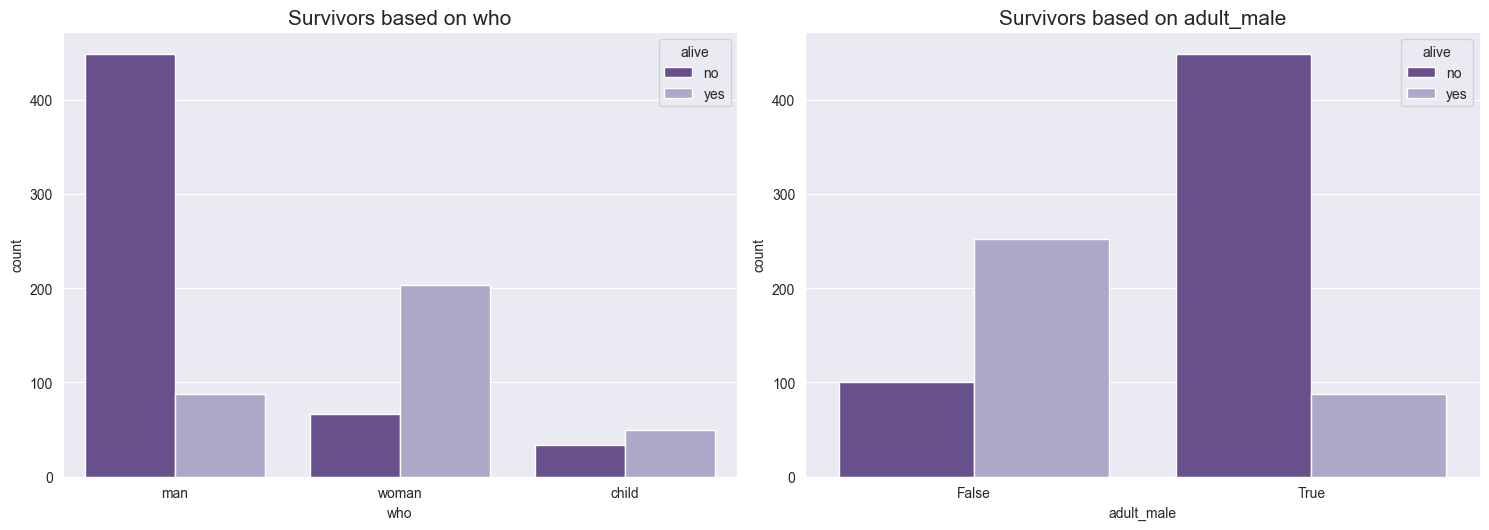

In [28]:
# set the figure size.
plt.figure(figsize = (15, 10))
display_cols = ['who', 'adult_male']

for i, name in enumerate(display_cols):
    ax = plt.subplot(2, 2, i+1)
    sns.countplot(data = titanic, x = name, hue = 'alive', ax = ax)
    ax.set_title(f'Survivors based on {name}',
                 size = 15)
plt.tight_layout()
plt.show()

Family Size.

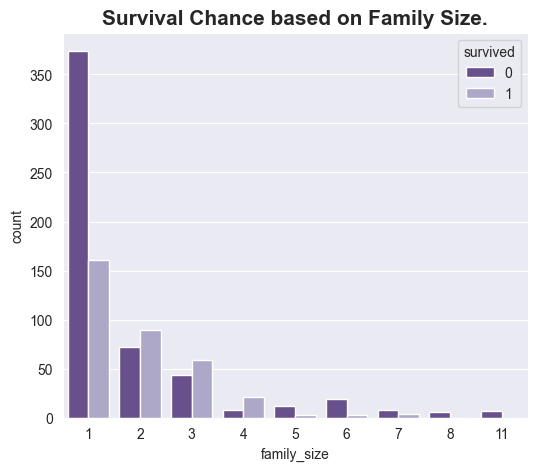

In [29]:
# set figure size.
plt.figure(figsize = (6, 5))

# countplot.
ax = sns.countplot(data = titanic, x = 'family_size', hue = 'survived')
ax.set_title('Survival Chance based on Family Size.', size = 15, weight = 'bold')

plt.show()

Age

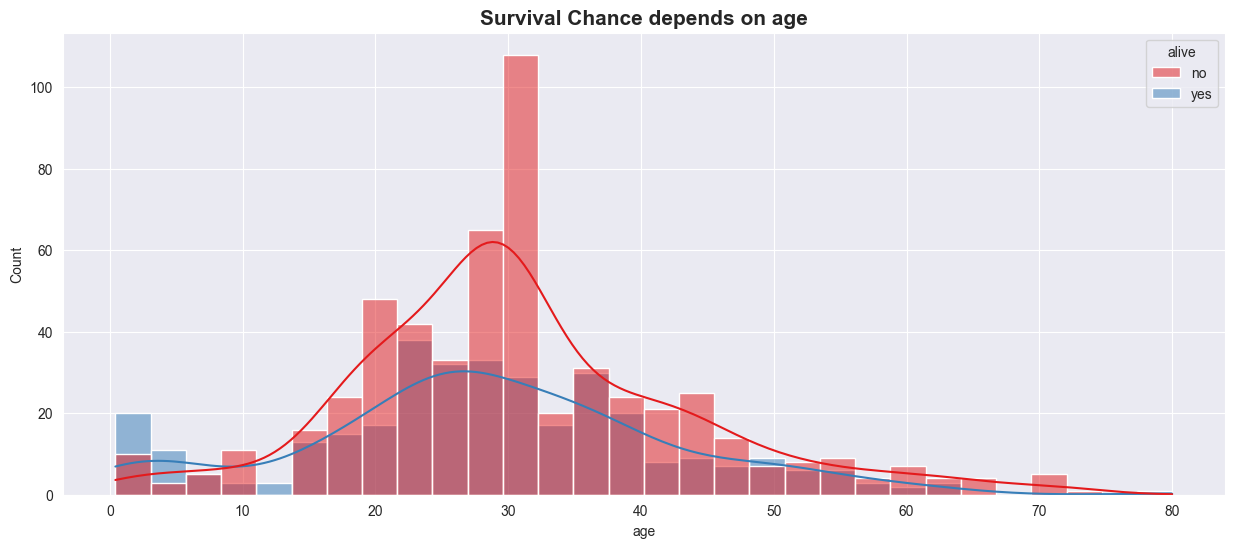

In [30]:
plt.figure(figsize = (15, 6))

ax = sns.histplot(data = titanic, x = 'age', bins = 30, kde = True,  hue = 'alive', palette = 'Set1')
ax.set_title('Survival Chance depends on age', size = 15, weight = 'bold')
plt.show()

Survivors

In [31]:
# get survivors with their genders.

male_survivors = titanic[(titanic['alive'].str.strip() == 'yes') & (titanic['sex'].str.strip() == 'male')]
female_survivors = titanic[(titanic['alive'].str.strip() == 'yes') & (titanic['sex'].str.strip() == 'female')]

survivors_on_genders = pd.concat([male_survivors, female_survivors])
survivors_on_genders

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,family_size
17,1,2,male,33.0,0,0,13.0000,S,Second,man,True,Southampton,yes,True,1
21,1,2,male,34.0,0,0,13.0000,S,Second,man,True,Southampton,yes,True,1
23,1,1,male,28.0,0,0,35.5000,S,First,man,True,Southampton,yes,True,1
36,1,3,male,27.0,0,0,7.2292,C,Third,man,True,Cherbourg,yes,True,1
55,1,1,male,39.0,0,0,35.5000,S,First,man,True,Southampton,yes,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,1,2,female,28.0,1,0,24.0000,C,Second,woman,False,Cherbourg,yes,False,2
875,1,3,female,15.0,0,0,7.2250,C,Third,child,False,Cherbourg,yes,True,1
879,1,1,female,56.0,0,1,83.1583,C,First,woman,False,Cherbourg,yes,False,2
880,1,2,female,25.0,0,1,26.0000,S,Second,woman,False,Southampton,yes,False,2


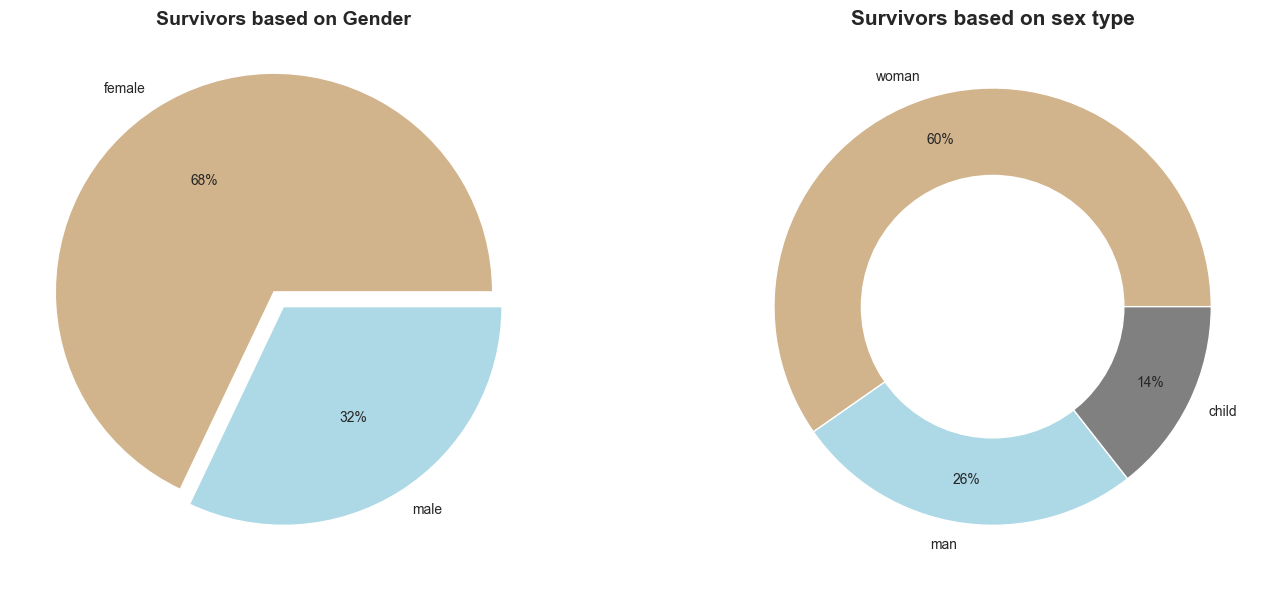

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# pie plot
axes[0].pie(survivors_on_genders['sex'].value_counts(), labels = survivors_on_genders['sex'].value_counts().index,
       autopct = '%1.0f%%', explode = [0.08, 0], colors = ['Tan', 'Lightblue'])
axes[0].set_title('Survivors based on Gender', size = 14, weight = 'bold')

# second
axes[1].pie(survivors_on_genders['who'].value_counts(), labels = survivors_on_genders['who'].value_counts().index,
       autopct = '%1.0f%%', colors = ['Tan', 'Lightblue', 'Grey'], pctdistance = 0.8)
axes[1].set_title('Survivors based on sex type', size = 15, weight = 'bold')
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()

Survivors based on Class.

In [33]:
# create survivor class dataframe.

survivors_class = survivors_on_genders.groupby(['class']).agg({'class': 'count'}).rename(columns = {'class' : 'count'})
survivors_class

,count
class,
First,134
Second,87
Third,119


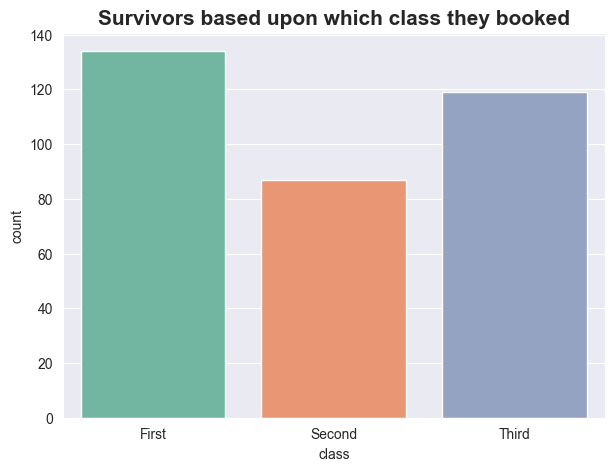

In [34]:
plt.figure(figsize = (7, 5))
ax = sns.barplot(data = survivors_class, x = survivors_class.index, y = 'count', palette = 'Set2')
ax.set_title('Survivors based upon which class they booked', size = 15, weight = 'bold')
plt.show()

Survivors depend on 'Age range'.

In [35]:
# get age range using pandas qcut method.
survivors_on_genders['age_range'] = pd.qcut(survivors_on_genders['age'], q = 8)

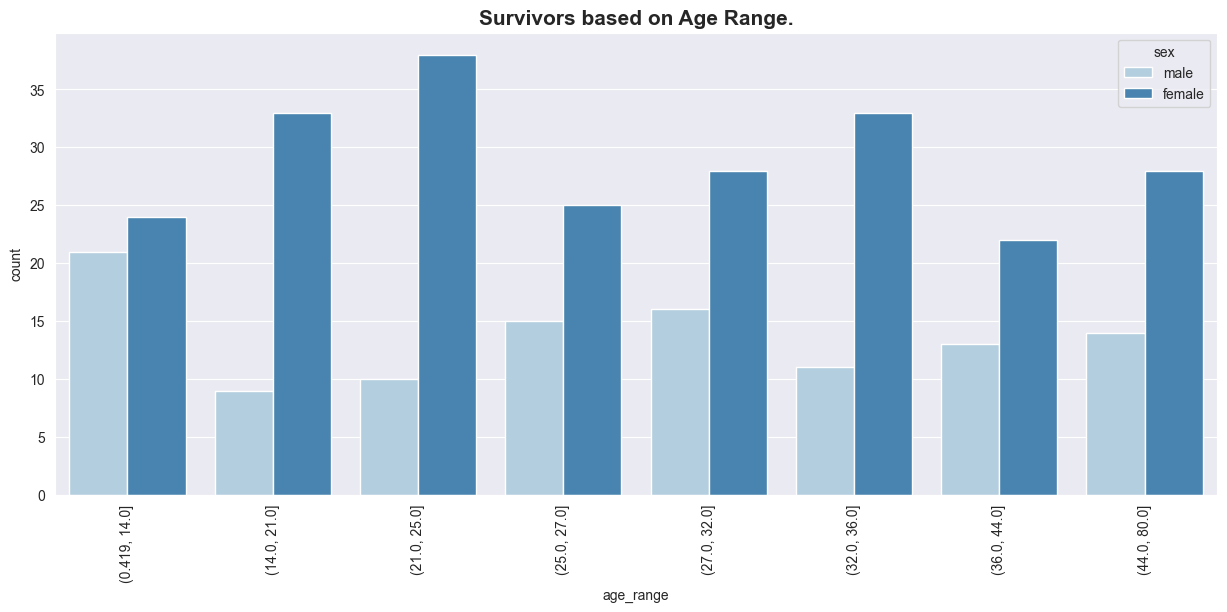

In [36]:
plt.figure(figsize = (15, 6))

ax = sns.countplot(data = survivors_on_genders, x = 'age_range', hue = 'sex', palette = 'Blues')
ax.set_title('Survivors based on Age Range.', size = 15, weight = 600)
plt.xticks(rotation = 90)
plt.show()

### Testing Model

In [135]:
test_df = titanic.drop(['embarked', 'alive', 'class', 'sibsp', 'parch'], axis = 1)

test_df.head()

,survived,pclass,sex,age,fare,who,adult_male,embark_town,alone,family_size
0,0,3,male,22.0,7.2500,man,True,Southampton,False,2
1,1,1,female,38.0,71.2833,woman,False,Cherbourg,False,2
2,1,3,female,26.0,7.9250,woman,False,Southampton,True,1
3,1,1,female,35.0,53.1000,woman,False,Southampton,False,2
4,0,3,male,35.0,8.0500,man,True,Southampton,True,1


Train Test Split

In [171]:
# import train test split.
from sklearn.model_selection import train_test_split

In [186]:
X = test_df.drop(['survived'], axis = 1)
y = test_df['survived']

In [187]:
X.head()

,pclass,sex,age,fare,who,adult_male,embark_town,alone,family_size
0,3,male,22.0,7.2500,man,True,Southampton,False,2
1,1,female,38.0,71.2833,woman,False,Cherbourg,False,2
2,3,female,26.0,7.9250,woman,False,Southampton,True,1
3,1,female,35.0,53.1000,woman,False,Southampton,False,2
4,3,male,35.0,8.0500,man,True,Southampton,True,1


In [188]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()

X_sampled, y_sampled = sampler.fit_resample(X, y)

print(f'Original X and y : {X.shape, y.shape}')
print(f'Resampled X and y : {X_sampled.shape, y_sampled.shape}')

Original X and y : ((889, 9), (889,))
Resampled X and y : ((1098, 9), (1098,))



Sampling

In [189]:
X_sampled.head()

,pclass,sex,age,fare,who,adult_male,embark_town,alone,family_size
0,3,male,22.0,7.2500,man,True,Southampton,False,2
1,1,female,38.0,71.2833,woman,False,Cherbourg,False,2
2,3,female,26.0,7.9250,woman,False,Southampton,True,1
3,1,female,35.0,53.1000,woman,False,Southampton,False,2
4,3,male,35.0,8.0500,man,True,Southampton,True,1


In [190]:
# break off validation set from training set.

X_train, X_valid, y_train, y_valid = train_test_split(X_sampled, y_sampled, test_size = 0.25, random_state = 42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((823, 9), (823,), (275, 9), (275,))

Category Encoding.

In [191]:
# select object_cols.
category_cols = [col for col in X_train.columns if X_train[col].dtypes in ['object', 'category', 'bool']]

category_cols

['sex', 'who', 'adult_male', 'embark_town', 'alone']

In [192]:
# import category encoding.
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

X_train[category_cols] = encoder.fit_transform(X_train[category_cols])
X_valid[category_cols] = encoder.transform(X_valid[category_cols])

X_train.head()

,pclass,sex,age,fare,who,adult_male,embark_town,alone,family_size
453,3,1.0,30.0,8.0500,1.0,1.0,2.0,1.0,1
92,3,1.0,26.0,20.5750,1.0,1.0,2.0,0.0,4
706,1,1.0,42.0,26.2875,1.0,1.0,2.0,1.0,1
730,3,1.0,11.0,18.7875,0.0,0.0,0.0,1.0,1
1065,3,0.0,2.0,12.2875,0.0,0.0,2.0,0.0,2


In [193]:
encoder.inverse_transform(X_train[category_cols].head())

array([['male', 'man', True, 'Southampton', True],
       ['male', 'man', True, 'Southampton', False],
       ['male', 'man', True, 'Southampton', True],
       ['male', 'child', False, 'Cherbourg', True],
       ['female', 'child', False, 'Southampton', False]], dtype=object)

In [194]:
# let's write a function to evaluate our model performance.
def evaluate(estimator, X_train, y_train, X_test, y_test):
    
    # training score.
    training_score = estimator.score(X_train, y_train) * 100
    
    # validation score.
    validation_score = estimator.score(X_test, y_test) * 100
    
    # make predictions.
    preds = estimator.predict(X_test)
    
    # MAE and MSE.
    acc = accuracy_score(y_pred = preds, y_true = y_test) * 100
    
    # print out model's performance.
    print(f'Model\'s Performance on training set : {training_score:.2f}%')
    print(f'Model\'s Performance on validation set : {validation_score:.2f}%')
    
    # error
    print(f'Accuracy_score : {acc:.2f}%')
    
    return preds

Logistic Regression.

In [195]:
from sklearn.linear_model import LogisticRegression

# initialise the model.
log = LogisticRegression(random_state = 42)

# train the model.
log.fit(X_train, y_train)

LogisticRegression(random_state=42)

Evaluation

In [196]:
# import evaluation metrics.
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [197]:
predictions = evaluate(estimator = log, X_train = X_train, y_train = y_train, X_test = X_valid, y_test = y_valid)

Model's Performance on training set : 81.65%
Model's Performance on validation set : 83.27%
Accuracy_score : 83.27%


In [198]:
# compare actual values and estimated values.
print(f'Actual Values : {y_valid[105:115].to_list()}')
print(f'Estimated Values : {predictions[105:115]}')

Actual Values : [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Estimated Values : [0 0 0 1 1 0 1 0 1 0]


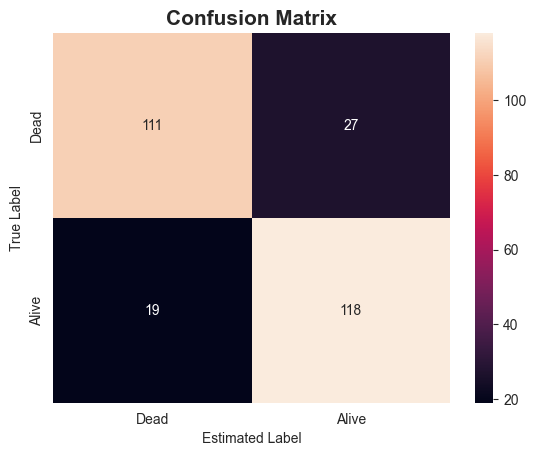

In [199]:
cm = confusion_matrix(y_pred=predictions, y_true = y_valid)

ax = sns.heatmap(cm, annot = True, fmt= '')
ax.set_title('Confusion Matrix', size = 15, weight= 'bold')
ax.set(xlabel = 'Estimated Label',
      ylabel = 'True Label')
ax.set_xticklabels(['Dead', 'Alive'])
ax.set_yticklabels(['Dead', 'Alive'])
plt.show()

In [200]:
print(classification_report(y_pred=predictions, y_true = y_valid))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83       138
           1       0.81      0.86      0.84       137

    accuracy                           0.83       275
   macro avg       0.83      0.83      0.83       275
weighted avg       0.83      0.83      0.83       275



Output Dataframe.

In [54]:
output = pd.DataFrame(y_valid)
output = output.rename(columns = {'survived' : 'Actual'}).reset_index()

output

,index,Actual
0,44,1
1,570,1
2,56,1
3,602,0
4,830,0
...,...,...
270,868,0
271,381,0
272,812,0
273,467,0


In [55]:
# drop index column.
output.drop(['index'], axis = 1, inplace = True)
output

,Actual
0,1
1,1
2,1
3,0
4,0
...,...
270,0
271,0
272,0
273,0


In [56]:
outcome = pd.DataFrame(predictions, columns = ['Estimated'])

final_output = pd.concat([output, outcome], axis = 1)
final_output

,Actual,Estimated
0,1,1
1,1,1
2,1,1
3,0,0
4,0,0
...,...,...
270,0,0
271,0,0
272,0,0
273,0,0


In [57]:
final_output['Actual'] = final_output['Actual'].map({1 : 'Alive', 0 : 'Dead'})
final_output['Estimated'] = final_output['Estimated'].map({1 : 'Alive', 0 : 'Dead'})

final_output

,Actual,Estimated
0,Alive,Alive
1,Alive,Alive
2,Alive,Alive
3,Dead,Dead
4,Dead,Dead
...,...,...
270,Dead,Dead
271,Dead,Dead
272,Dead,Dead
273,Dead,Dead


### Save as csv file.

In [58]:
final_output.to_csv('output.csv', index= False)

In [59]:
output_df = pd.read_csv('output.csv')
output_df

,Actual,Estimated
0,Alive,Alive
1,Alive,Alive
2,Alive,Alive
3,Dead,Dead
4,Dead,Dead
...,...,...
270,Dead,Dead
271,Dead,Dead
272,Dead,Dead
273,Dead,Dead


Decision Tree

In [201]:
# take a look at the data.
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,family_size
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False,2
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False,2
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False,2
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True,1


In [202]:
titanic.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
family_size    0
dtype: int64

In [203]:
# copy the data in case it occurs any changes in original data.

copy_df = titanic.copy()

In [204]:
copy_df.drop(['embarked', 'class', 'alive', 'sibsp', 'parch'], axis = 1, inplace = True)

copy_df.head()

,survived,pclass,sex,age,fare,who,adult_male,embark_town,alone,family_size
0,0,3,male,22.0,7.2500,man,True,Southampton,False,2
1,1,1,female,38.0,71.2833,woman,False,Cherbourg,False,2
2,1,3,female,26.0,7.9250,woman,False,Southampton,True,1
3,1,1,female,35.0,53.1000,woman,False,Southampton,False,2
4,0,3,male,35.0,8.0500,man,True,Southampton,True,1


Feature Engineering.

In [205]:
X = copy_df.drop(['survived'], axis = 1)
y = copy_df['survived']

In [206]:
from imblearn.over_sampling import RandomOverSampler

new_sampler = RandomOverSampler()

X_sampled_new, y_sampled_new = new_sampler.fit_resample(X, y)

print(f'Original X and y : {X.shape, y.shape}')
print(f'Resampled X and y : {X_sampled_new.shape, y_sampled_new.shape}')

Original X and y : ((889, 9), (889,))
Resampled X and y : ((1098, 9), (1098,))


In [207]:
# break off validation set from training set.

X_train, X_valid, y_train, y_valid = train_test_split(X_sampled_new, y_sampled_new, test_size = 0.25, random_state = 42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((823, 9), (823,), (275, 9), (275,))

In [208]:
# import category encoding.
from sklearn.preprocessing import OrdinalEncoder

new_encoder = OrdinalEncoder()

X_train[category_cols] = new_encoder.fit_transform(X_train[category_cols])
X_valid[category_cols] = new_encoder.transform(X_valid[category_cols])

X_train.head()

,pclass,sex,age,fare,who,adult_male,embark_town,alone,family_size
453,3,1.0,30.0,8.0500,1.0,1.0,2.0,1.0,1
92,3,1.0,26.0,20.5750,1.0,1.0,2.0,0.0,4
706,1,1.0,42.0,26.2875,1.0,1.0,2.0,1.0,1
730,3,1.0,11.0,18.7875,0.0,0.0,0.0,1.0,1
1065,2,1.0,32.0,26.0000,1.0,1.0,2.0,0.0,2


In [209]:
# import Decision Tree.

from sklearn.tree import DecisionTreeClassifier

dc = DecisionTreeClassifier(criterion = 'entropy',  random_state = 42)

# train the model.
dc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [210]:
predictions_tree = evaluate(estimator=dc, X_train=X_train, y_train=y_train, X_test=X_valid, y_test=y_valid)

Model's Performance on training set : 99.03%
Model's Performance on validation set : 86.18%
Accuracy_score : 86.18%


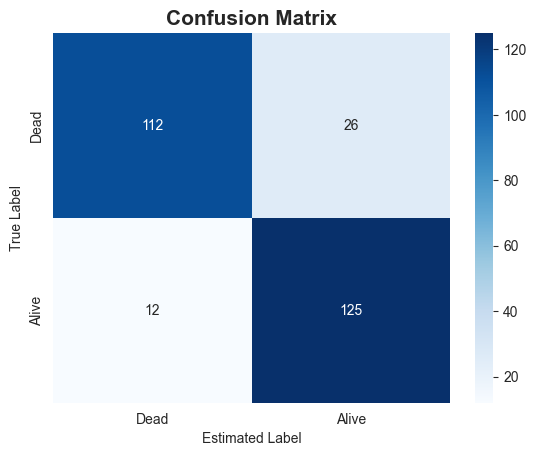

In [211]:
cm_tree = confusion_matrix(y_pred=predictions_tree, y_true = y_valid)

ax = sns.heatmap(cm_tree, annot = True, fmt = '', cmap = 'Blues')
ax.set_title('Confusion Matrix', size = 15, weight = 'bold')
ax.set(xlabel = 'Estimated Label',
      ylabel = 'True Label')
ax.set_xticklabels(['Dead', 'Alive'])
ax.set_yticklabels(['Dead', 'Alive'])
plt.show()

In [212]:
print(classification_report(y_pred=predictions_tree, y_true = y_valid))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       138
           1       0.83      0.91      0.87       137

    accuracy                           0.86       275
   macro avg       0.87      0.86      0.86       275
weighted avg       0.87      0.86      0.86       275

